# Data **Understanding**


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

# Fixer une graine aléatoire
RANDOM_STATE = 42
data=pd.read_csv("dataAssurance.csv")

In [4]:
df = pd.read_csv("dataAssurance.csv")

In [5]:
print("=== Dimensions du dataset ===")
print(f"Lignes : {df.shape[0]}, Colonnes : {df.shape[1]}")

=== Dimensions du dataset ===
Lignes : 1443, Colonnes : 7


In [6]:
print("\n=== Types de données ===")
print(df.dtypes)


=== Types de données ===
age         float64
sex          object
bmi         float64
children    float64
smoker       object
region       object
charges     float64
dtype: object


In [7]:
# Aperçu des premières lignes
print("Aperçu du dataset :")
display(df.head())

Aperçu du dataset :


,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400
1,18.0,male,33.770,1.0,no,southeast,1725.55230
2,28.0,male,33.000,3.0,no,southeast,4449.46200
3,33.0,male,22.705,0.0,no,northwest,21984.47061
4,32.0,male,28.880,0.0,no,northwest,3866.85520


In [8]:
# Informations générales
print("\nInformations générales :")
print(df.info())


Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1443 entries, 0 to 1442
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1406 non-null   float64
 1   sex       1405 non-null   object 
 2   bmi       1410 non-null   float64
 3   children  1414 non-null   float64
 4   smoker    1417 non-null   object 
 5   region    1410 non-null   object 
 6   charges   1414 non-null   float64
dtypes: float64(4), object(3)
memory usage: 79.0+ KB
None


In [9]:
# Statistiques descriptives
print("\nStatistiques descriptives :")
display(df.describe(include="all"))


Statistiques descriptives :


,age,sex,bmi,children,smoker,region,charges
count,1406.000000,1405,1410.000000,1414.000000,1417,1410,1414.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,719,NaN,NaN,1132,381,NaN
mean,39.179232,NaN,30.637681,1.086280,NaN,NaN,13179.307173
std,14.067120,NaN,6.112450,1.196088,NaN,NaN,11987.371506
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,26.000000,NaN,26.220000,0.000000,NaN,NaN,4748.057175
50%,39.000000,NaN,30.302500,1.000000,NaN,NaN,9369.615750
75%,51.000000,NaN,34.656250,2.000000,NaN,NaN,16547.261588


In [10]:
# 2. Statistiques descriptives
print("\n=== Statistiques descriptives ===")
display(df.describe(include="all").T)



=== Statistiques descriptives ===


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,1406.0,NaN,NaN,NaN,39.179232,14.06712,18.0,26.0,39.0,51.0,64.0
sex,1405,2,male,719,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bmi,1410.0,NaN,NaN,NaN,30.637681,6.11245,15.96,26.22,30.3025,34.65625,53.13
children,1414.0,NaN,NaN,NaN,1.08628,1.196088,0.0,0.0,1.0,2.0,5.0
smoker,1417,2,no,1132,NaN,NaN,NaN,NaN,NaN,NaN,NaN
region,1410,4,southeast,381,NaN,NaN,NaN,NaN,NaN,NaN,NaN
charges,1414.0,NaN,NaN,NaN,13179.307173,11987.371506,1121.8739,4748.057175,9369.61575,16547.261588,63770.42801


In [11]:
# Vérification des valeurs manquantes
print("\nValeurs manquantes par colonne :")
print(df.isna().sum())


Valeurs manquantes par colonne :
age         37
sex         38
bmi         33
children    29
smoker      26
region      33
charges     29
dtype: int64


# Data *Preparation*

In [12]:
# 1. Suppression des doublons
print("Taille avant suppression des doublons :", df.shape)
df = df.drop_duplicates()
print("Taille après suppression des doublons :", df.shape)


Taille avant suppression des doublons : (1443, 7)
Taille après suppression des doublons : (1338, 7)


In [13]:
# 2. Gestion des valeurs manquantes
# Ici, on peut choisir de supprimer ou d’imputer.
df = df.fillna(df.mean(numeric_only=True))


In [14]:
# 3. Vérification des valeurs aberrantes simples (ex: âge négatif, BMI < 10 ou > 70)
df = df[df["age"] > 0]
df = df[(df["bmi"] >= 10) & (df["bmi"] <= 70)]

In [17]:
# 4. Détection des outliers via les IQR (interquartiles)
def detect_outliers_iqr(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = series[(series < lower) | (series > upper)]
    return outliers, lower, upper

for col in numeric_cols:
    outliers, low, up = detect_outliers_iqr(df[col])
    print(f"\nColonne : {col}")
    print(f" - Q1 = {df[col].quantile(0.25):.2f}")
    print(f" - Q3 = {df[col].quantile(0.75):.2f}")
    print(f" - IQR = {df[col].quantile(0.75) - df[col].quantile(0.25):.2f}")
    print(f" - Limite basse = {low:.2f}, Limite haute = {up:.2f}")
    print(f" - Nb outliers détectés : {len(outliers)}")


Colonne : age
 - Q1 = 27.00
 - Q3 = 51.00
 - IQR = 24.00
 - Limite basse = -9.00, Limite haute = 87.00
 - Nb outliers détectés : 0

Colonne : bmi
 - Q1 = 26.40
 - Q3 = 34.43
 - IQR = 8.03
 - Limite basse = 14.35, Limite haute = 46.48
 - Nb outliers détectés : 14

Colonne : children
 - Q1 = 0.00
 - Q3 = 2.00
 - IQR = 2.00
 - Limite basse = -3.00, Limite haute = 5.00
 - Nb outliers détectés : 0

Colonne : charges
 - Q1 = 4828.59
 - Q3 = 16132.90
 - IQR = 11304.31
 - Limite basse = -12127.88, Limite haute = 33089.36
 - Nb outliers détectés : 147


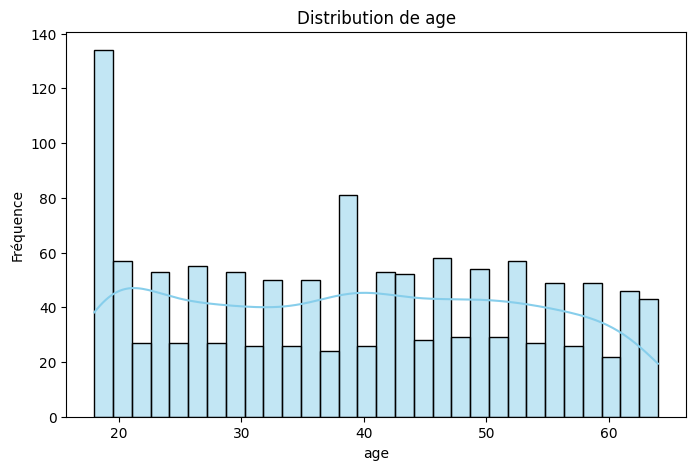

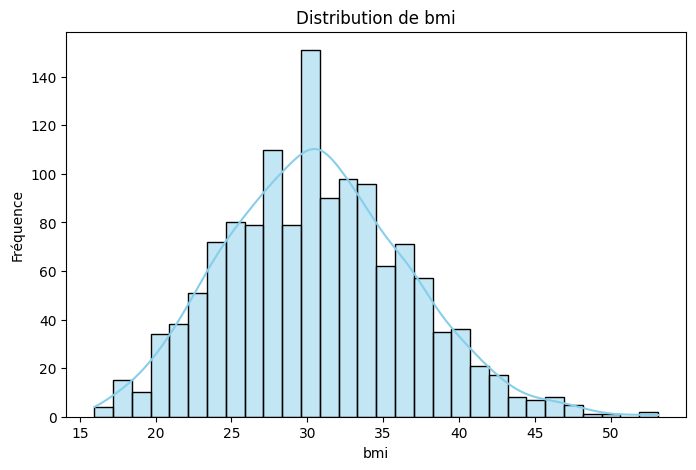

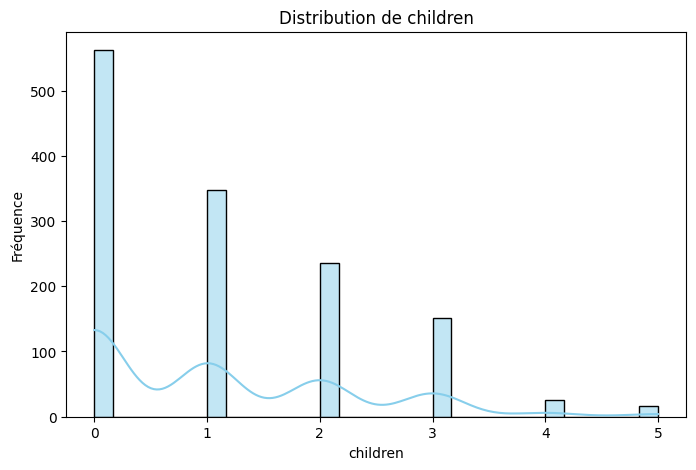

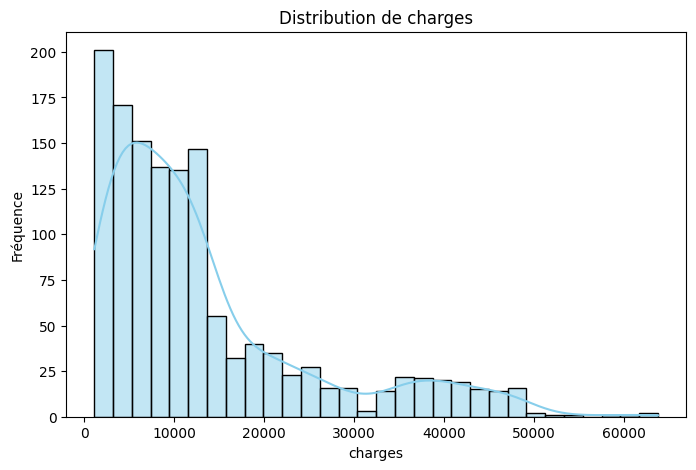

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# 4. Distribution des variables numériques (histogrammes + KDE)
numeric_cols = ["age", "bmi", "children", "charges"]

for col in numeric_cols:
    plt.figure(figsize=(8,5))
    sns.histplot(df[col], kde=True, bins=30, color="skyblue")
    plt.title(f"Distribution de {col}")
    plt.xlabel(col)
    plt.ylabel("Fréquence")
    plt.show()

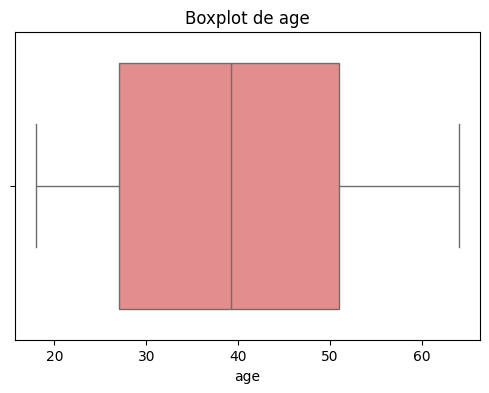

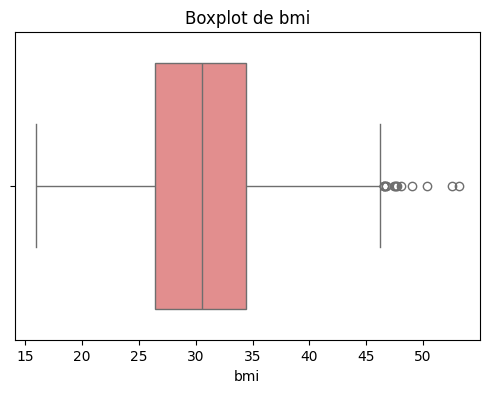

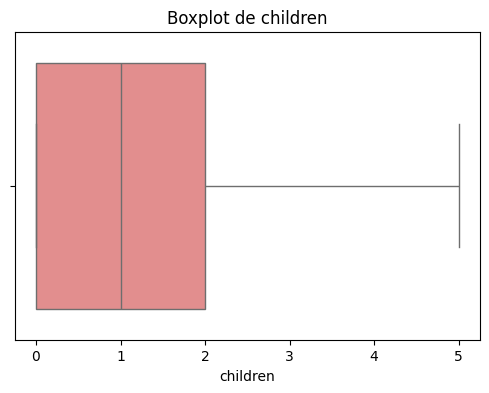

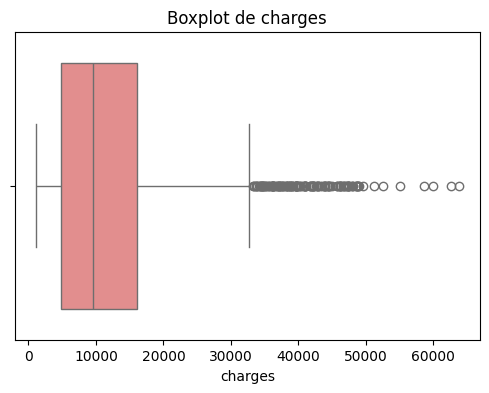

In [23]:
# 5. Boxplots pour détecter les valeurs extrêmes
for col in numeric_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], color="lightcoral")
    plt.title(f"Boxplot de {col}")
    plt.show()

/tmp/ipython-input-3359000227.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="Set3")


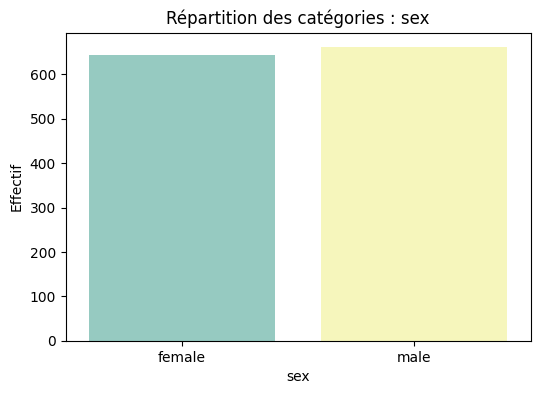

/tmp/ipython-input-3359000227.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="Set3")


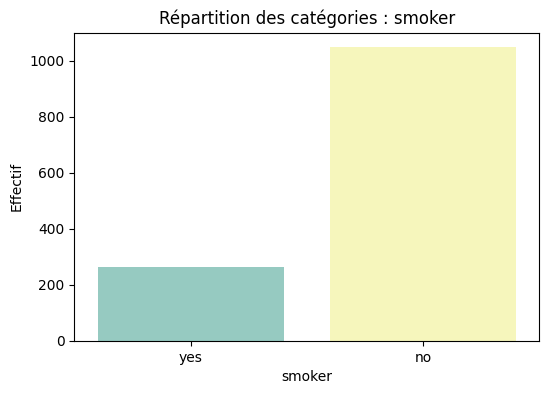

/tmp/ipython-input-3359000227.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df[col], palette="Set3")


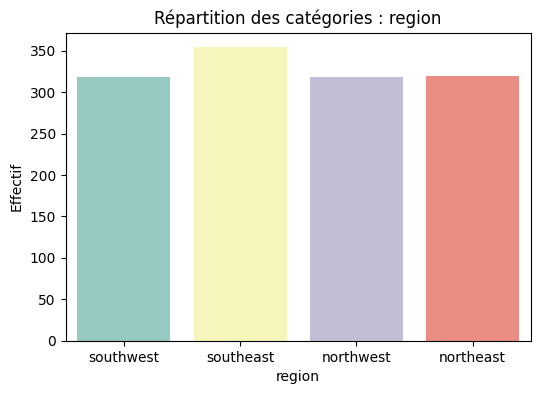

In [24]:
# 6. Variables catégorielles (répartition par barplot)
categorical_cols = ["sex", "smoker", "region"]

for col in categorical_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=df[col], palette="Set3")
    plt.title(f"Répartition des catégories : {col}")
    plt.xlabel(col)
    plt.ylabel("Effectif")
    plt.show()

/tmp/ipython-input-63005967.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="smoker", y="charges", data=df, palette="Set2")


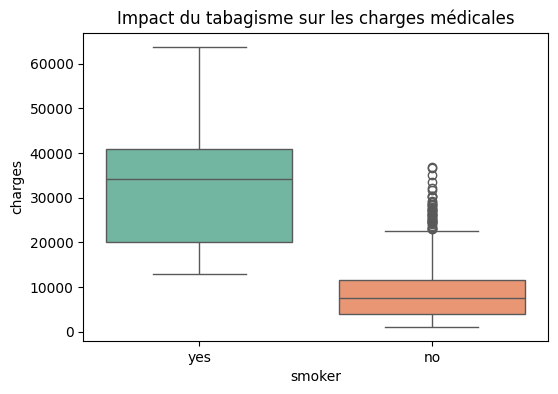

In [25]:
# 7. Relation charges vs fumeur
plt.figure(figsize=(6,4))
sns.boxplot(x="smoker", y="charges", data=df, palette="Set2")
plt.title("Impact du tabagisme sur les charges médicales")
plt.show()

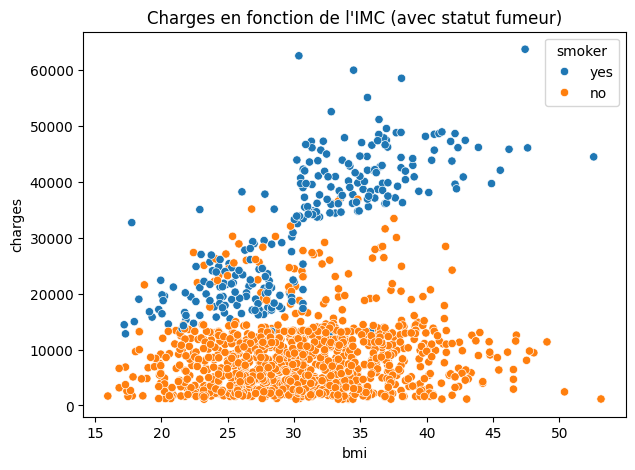

In [26]:
# 8. Relation charges vs IMC
plt.figure(figsize=(7,5))
sns.scatterplot(x="bmi", y="charges", hue="smoker", data=df)
plt.title("Charges en fonction de l'IMC (avec statut fumeur)")
plt.show()

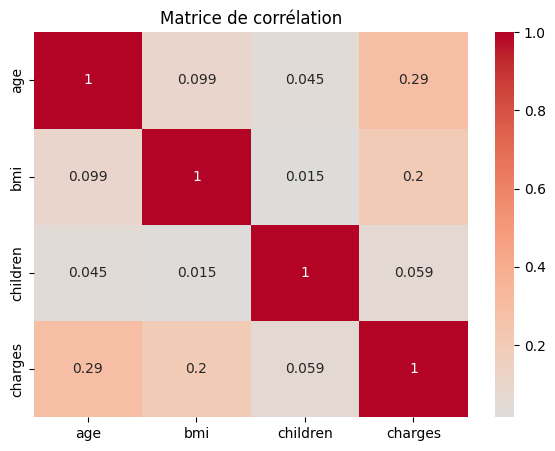

In [27]:
# 9. Matrice de corrélation (seulement variables numériques)
plt.figure(figsize=(7,5))
corr = df[numeric_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Matrice de corrélation")
plt.show()

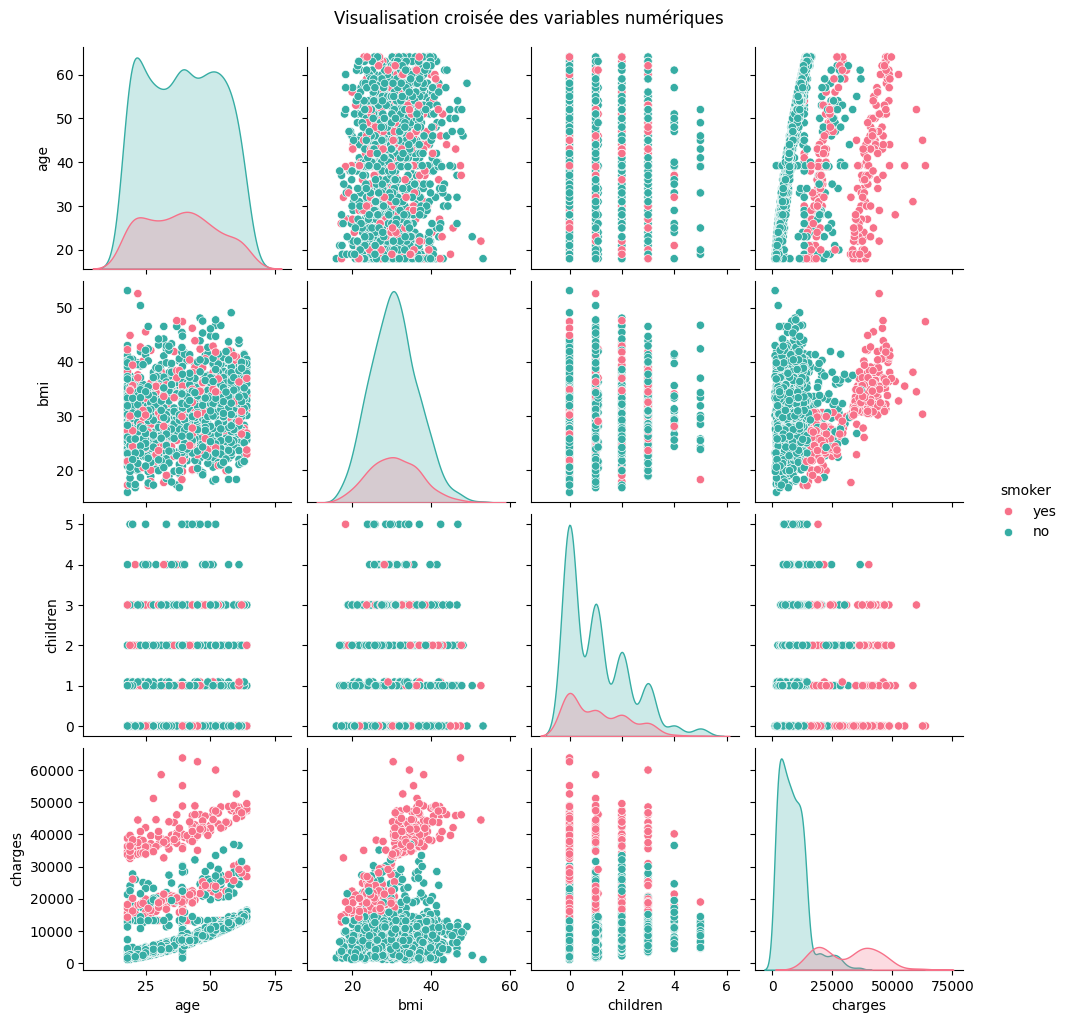

In [28]:
# 10. Pairplot (relation croisée entre variables)
sns.pairplot(df[numeric_cols + ["smoker"]], hue="smoker", diag_kind="kde", palette="husl")
plt.suptitle("Visualisation croisée des variables numériques", y=1.02)
plt.show()

In [29]:
# 4. Création de deux jeux de variables :
# - FS_A : profil démographique et style de vie (sans charges)
# - FS_B : FS_A + variable charges

fs_a_features = ["age", "bmi", "children", "sex", "smoker", "region"]
fs_b_features = fs_a_features + ["charges"]


In [30]:
# Séparation numérique et catégorielle
def split_feature_types(columns, frame):
    num = [c for c in columns if np.issubdtype(frame[c].dtype, np.number)]
    cat = [c for c in columns if c not in num]
    return num, cat

num_a, cat_a = split_feature_types(fs_a_features, df)
num_b, cat_b = split_feature_types(fs_b_features, df)


In [31]:
# Préprocesseur pour FS_A
preprocess_a = ColumnTransformer([
    ("num", StandardScaler(), num_a),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_a),
])

# Préprocesseur pour FS_B
preprocess_b = ColumnTransformer([
    ("num", StandardScaler(), num_b),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_b),
])

## **#Modeling**

In [33]:
# Données d’entrée
X_a = df[fs_a_features]
X_b = df[fs_b_features]

# 1. Pipelines Isolation Forest
isoforest_a = Pipeline([
    ("prep", preprocess_a),
    ("model", IsolationForest(
        n_estimators=300,
        max_samples="auto",
        contamination=0.05,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

isoforest_b = Pipeline([
    ("prep", preprocess_b),
    ("model", IsolationForest(
        n_estimators=300,
        max_samples="auto",
        contamination=0.05,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

# 2. Pipelines One-Class SVM (avec tuning léger + novelty)
from sklearn.svm import OneClassSVM

TARGET_OUTLIER_RATE = 0.05

ocsvm_a = Pipeline([
    ("prep", preprocess_a),
    ("model", OneClassSVM(kernel="rbf", gamma="scale", nu=TARGET_OUTLIER_RATE))
])
ocsvm_b = Pipeline([
    ("prep", preprocess_b),
    ("model", OneClassSVM(kernel="rbf", gamma="scale", nu=TARGET_OUTLIER_RATE))
])


# 3. Entraînement des modèles
print("Entraînement des modèles en cours...")

isoforest_a.fit(X_a)
isoforest_b.fit(X_b)

# OCSVM is trained on normal data only in novelty detection, but here we fit on all data
# as per the evaluation logic.
ocsvm_a.fit(X_a)
ocsvm_b.fit(X_b)

print("✅ Modèles entraînés avec succès (CRISP-DM jusqu'à Modélisation).")

# Sauvegarde des modèles (optionnel)
joblib.dump(isoforest_a, "isoforest_FS_A.joblib")
joblib.dump(isoforest_b, "isoforest_FS_B.joblib")
joblib.dump(ocsvm_a, "ocsvm_FS_A.joblib")
joblib.dump(ocsvm_b, "ocsvm_FS_B.joblib")

Entraînement des modèles en cours...
✅ Modèles entraînés avec succès (CRISP-DM jusqu'à Modélisation).


['ocsvm_FS_B.joblib']

In [40]:
# ================================
# ÉVALUATION GÉNÉRIQUE TOUS MODÈLES (version stable)
# ================================
import numpy as np
import pandas as pd

# 0) Prépare les jeux de features (adaptés à tes préprocess)
X_map = {
    "IF_A": X_a,
    "IF_B": X_b,
    "OCSVM_A": X_a,
    "OCSVM_B": X_b,
}

# 1) Regroupe les pipelines
models = {
    "IF_A": isoforest_a,
    "IF_B": isoforest_b,
    "OCSVM_A": ocsvm_a,
    "OCSVM_B": ocsvm_b,
}

# Paramètre métier
try:
    TARGET_OUTLIER_RATE
except NameError:
    TARGET_OUTLIER_RATE = 0.05  # 5% par défaut

# 2) Copie du DF résultats
df_results = df.copy()












In [41]:
# 2-bis) Utilitaire: transforme scores → prédictions
def anomaly_from_scores(scores, rate=-1):
    if rate == -1:
        # Cas spécial : aucune anomalie (tout normal)
        return np.zeros_like(scores, dtype=int)
    else:
        # Seuil = quantile haut (ex: 95% si rate=0.05 → top 5% anomalies)
        threshold = np.quantile(scores, 1 - rate)
        return (scores >= threshold).astype(int)  # 1 = anomalie, 0 = normal

In [42]:
# 3) Calcul des scores + prédictions
for name, model in models.items():
    X = X_map[name]

    # On applique explicitement le preprocessing entraîné (imputation + OHE + scaling)
    Z = model.named_steps["prep"].transform(X)
    algo = model.named_steps["model"]

    # --- Calcul des scores bruts selon l'algo ---
    if name.startswith("IF"):
        raw_score = algo.score_samples(Z)        # grand = normal
    else:
        raw_score = algo.decision_function(Z)    # grand = normal

    # --- Uniformisation : grand = anormal ---
    anomaly_score = -raw_score

    # --- Seuil métier par quantile ---
    preds_bin = anomaly_from_scores(anomaly_score, rate=TARGET_OUTLIER_RATE)  # 1 = anomalie, 0 = normal
    preds_pm1 = np.where(preds_bin == 1, -1, 1)  # compatibilité sklearn (-1=anom, +1=normal)

    # Stockage
    df_results[f"{name}_score"] = anomaly_score
    df_results[f"{name}_pred_bin"] = preds_bin
    df_results[f"{name}_pred"] = preds_pm1

In [43]:

# 4) Compter les anomalies par modèle
print("=== Nombre d’anomalies détectées (par modèle) ===")
for name in models.keys():
    n_anom = int(df_results[f"{name}_pred_bin"].sum())
    rate = df_results[f"{name}_pred_bin"].mean() * 100
    print(f"{name:10s}: {n_anom}  ({rate:.2f} %)")



=== Nombre d’anomalies détectées (par modèle) ===
IF_A      : 67  (5.01 %)
IF_B      : 67  (5.01 %)
OCSVM_A   : 67  (5.01 %)
OCSVM_B   : 67  (5.01 %)


In [44]:
# 5) Tableau récap
summary = []
for name in models.keys():
    summary.append({
        "model": name,
        "n_rows": len(df_results),
        "n_anomalies": int(df_results[f"{name}_pred_bin"].sum()),
        "anomaly_rate_%": 100 * df_results[f"{name}_pred_bin"].mean()
    })
summary_df = pd.DataFrame(summary).sort_values("model")
display(summary_df)

,model,n_rows,n_anomalies,anomaly_rate_%
0,IF_A,1338,67,5.007474
1,IF_B,1338,67,5.007474
2,OCSVM_A,1338,67,5.007474
3,OCSVM_B,1338,67,5.007474


In [45]:
# ================================
# SANITY CHECKS
# ================================

print("\n=== Contrôle du taux d'anomalies ===")
tol = 0.02
for name in models.keys():
    rate_obs = float(df_results[f"{name}_pred_bin"].mean())
    delta = rate_obs - TARGET_OUTLIER_RATE
    status = "OK" if abs(delta) <= tol else "⚠️"
    print(f"{name:10s} -> obs={rate_obs:.3f}  cible={TARGET_OUTLIER_RATE:.3f}  Δ={delta:+.3f}  {status}")

print("\n=== Cohérence des scores (grand = anormal) ===")
for name, model in models.items():
    X = X_map[name]
    Z = model.named_steps["prep"].transform(X)
    algo = model.named_steps["model"]
    if name.startswith("IF"):
        raw = algo.score_samples(Z)
    else:
        raw = algo.decision_function(Z)
    anomaly_score = df_results[f"{name}_score"].to_numpy()
    corr = np.corrcoef(anomaly_score, -raw)[0,1]
    status = "OK" if corr > 0.95 else ("⚠️" if corr > 0.8 else "❗")
    print(f"{name:10s} corr(score, -raw): {corr:.3f} {status}")

print("\n=== Consensus IF vs OCSVM ===")
def consensus_report(prefix_if, prefix_svm):
    a = df_results[f"{prefix_if}_pred_bin"].to_numpy()
    b = df_results[f"{prefix_svm}_pred_bin"].to_numpy()
    agree = (a == b).mean()
    both_anom = ((a == 1) & (b == 1)).mean()
    print(f"{prefix_if} vs {prefix_svm} -> Accord global: {agree*100:.2f}% | Anomalies communes: {both_anom*100:.2f}%")

consensus_report("IF_A", "OCSVM_A")
consensus_report("IF_B", "OCSVM_B")


=== Contrôle du taux d'anomalies ===
IF_A       -> obs=0.050  cible=0.050  Δ=+0.000  OK
IF_B       -> obs=0.050  cible=0.050  Δ=+0.000  OK
OCSVM_A    -> obs=0.050  cible=0.050  Δ=+0.000  OK
OCSVM_B    -> obs=0.050  cible=0.050  Δ=+0.000  OK

=== Cohérence des scores (grand = anormal) ===
IF_A       corr(score, -raw): 1.000 OK
IF_B       corr(score, -raw): 1.000 OK
OCSVM_A    corr(score, -raw): 1.000 OK
OCSVM_B    corr(score, -raw): 1.000 OK

=== Consensus IF vs OCSVM ===
IF_A vs OCSVM_A -> Accord global: 92.68% | Anomalies communes: 1.35%
IF_B vs OCSVM_B -> Accord global: 93.72% | Anomalies communes: 1.87%


In [46]:
# 6) Top-K à auditer
K = 10
for name in models.keys():
    print(f"\n=== Top {K} anomalies à auditer ({name}) ===")
    cols_show = ["age","bmi","children","smoker","charges", f"{name}_score"]
    ex = (
        df_results
        .loc[df_results[f"{name}_pred_bin"] == 1]
        .sort_values(f"{name}_score", ascending=False)
        .head(K)
    )
    display(ex[cols_show] if all(c in ex.columns for c in cols_show) else ex.head(K))


=== Top 10 anomalies à auditer (IF_A) ===


,age,bmi,children,smoker,charges,IF_A_score
1131,27.0,45.90000,2.0,NaN,3693.42800,0.682917
837,56.0,28.31000,0.0,NaN,11657.71890,0.679827
1031,55.0,35.20000,0.0,NaN,44423.80300,0.679628
545,49.0,25.84000,2.0,NaN,23807.24060,0.677991
747,19.0,21.75500,0.0,no,1627.28245,0.658619
1288,20.0,39.40000,2.0,yes,38344.56600,0.656355
773,19.0,28.88000,0.0,yes,17748.50620,0.641138
857,25.0,24.13000,0.0,yes,15817.98570,0.637895
912,59.0,30.66938,3.0,NaN,14382.70905,0.637213
1232,54.0,24.60500,3.0,NaN,12479.70895,0.635852



=== Top 10 anomalies à auditer (IF_B) ===


,age,bmi,children,smoker,charges,IF_B_score
1031,55.0,35.200,0.0,NaN,44423.80300,0.685236
545,49.0,25.840,2.0,NaN,23807.24060,0.675677
837,56.0,28.310,0.0,NaN,11657.71890,0.675002
1131,27.0,45.900,2.0,NaN,3693.42800,0.672738
558,35.0,34.105,3.0,NaN,39983.42595,0.644096
747,19.0,21.755,0.0,no,1627.28245,0.642388
1288,20.0,39.400,2.0,yes,38344.56600,0.641497
773,19.0,28.880,0.0,yes,17748.50620,0.637901
857,25.0,24.130,0.0,yes,15817.98570,0.637225
420,64.0,33.880,0.0,NaN,46889.26120,0.637064



=== Top 10 anomalies à auditer (OCSVM_A) ===


,age,bmi,children,smoker,charges,OCSVM_A_score
438,52.0,46.75,5.0,no,12592.5345,2.690468
1085,39.0,18.30,5.0,yes,19023.2600,1.972807
1317,18.0,53.13,0.0,no,1163.4627,1.807521
640,33.0,42.40,5.0,no,6666.2430,1.450981
1047,22.0,52.58,1.0,yes,44501.3982,1.131434
166,20.0,37.00,5.0,no,4830.6300,0.968155
116,58.0,49.06,0.0,no,11381.3254,0.924564
1131,27.0,45.90,2.0,NaN,3693.4280,0.846518
172,18.0,15.96,0.0,no,1694.7964,0.623680
250,18.0,17.29,2.0,yes,12829.4551,0.535532



=== Top 10 anomalies à auditer (OCSVM_B) ===


,age,bmi,children,smoker,charges,OCSVM_B_score
438,52.000000,46.750,5.0,no,12592.53450,2.224585
543,39.207055,47.410,0.0,yes,63770.42801,2.035707
1317,18.000000,53.130,0.0,no,1163.46270,1.851504
1047,22.000000,52.580,1.0,yes,44501.39820,1.825512
1085,39.000000,18.300,5.0,yes,19023.26000,1.728194
1300,45.000000,30.360,0.0,yes,62592.87309,1.501772
640,33.000000,42.400,5.0,no,6666.24300,0.972775
1131,27.000000,45.900,2.0,NaN,3693.42800,0.972566
1012,61.000000,33.330,4.0,no,36580.28216,0.867758
1230,52.000000,34.485,3.0,yes,60021.39897,0.831209


In [35]:
# ================================
# SANITY CHECKS (taux, cohérence, consensus)
# À placer juste après la cellule d'évaluation
# ================================
import numpy as np
import pandas as pd

# 1) Vérifier que le taux d'anomalies observé ~ TARGET_OUTLIER_RATE
print("=== Contrôle du taux d'anomalies (binaire 1=anomalie) ===")
tol = 0.02  # tolérance absolue de ±2 points
for name in models.keys():
    rate_obs = float(df_results[f"{name}_pred_bin"].mean())
    delta = rate_obs - TARGET_OUTLIER_RATE
    status = "OK" if abs(delta) <= tol else "⚠️"
    print(f"{name:10s} -> obs={rate_obs:.3f}  cible={TARGET_OUTLIER_RATE:.3f}  Δ={delta:+.3f}  {status}")
print()

# 2) Sanity: cohérence signe/échelle des scores (plus GRAND = + anormal)
#    On attend corr(score_anormal, -raw_score_normal) > 0
print("=== Cohérence des scores (grand = + anormal) ===")
for name, model in models.items():
    X = X_map[name]
    Z = model.named_steps["prep"].transform(X)
    if name.startswith("IF"):
        raw = model.named_steps["model"].score_samples(Z)  # grand = normal
    else:
        raw = model.named_steps["model"].decision_function(Z)  # grand = normal
    anomaly_score = df_results[f"{name}_score"].to_numpy()   # grand = anormal (déjà inversé dans l'éval)
    corr = np.corrcoef(anomaly_score, -raw)[0,1]
    status = "OK" if corr > 0.95 else ("⚠️" if corr > 0.8 else "❗")
    print(f"{name:10s} corr(score, -raw): {corr:.3f} {status}")
print()

# 3) Consensus IF vs OCSVM (même espace de features : A et B)
def consensus_report(prefix_if, prefix_svm):
    a = df_results[f"{prefix_if}_pred_bin"].to_numpy()
    b = df_results[f"{prefix_svm}_pred_bin"].to_numpy()
    agree = (a == b).mean()
    both_anom = ((a == 1) & (b == 1)).mean()
    print(f"Consensus {prefix_if} vs {prefix_svm} -> Accord global: {agree*100:.2f}%  |  'Anomalies communes': {both_anom*100:.2f}%")

print("=== Consensus IF vs OCSVM ===")
consensus_report("IF_A", "OCSVM_A")
consensus_report("IF_B", "OCSVM_B")
print()

# 4) Règles métier: vérifier corrélation simple avec flags (si présents)
rule_cols = [c for c in df_results.columns if c.startswith("rule_")]
if rule_cols:
    print("=== Corrélation (point-biserial approx.) entre règles métier et scores ===")
    for name in models.keys():
        s = df_results[f"{name}_score"].to_numpy()
        for rc in rule_cols:
            r = np.corrcoef(s, df_results[rc].to_numpy())[0,1]
            print(f"{name:10s} ~ {rc:28s} : corr={r:.3f}")
    print()

# 5) Top-K à auditer (par modèle) — échantillon actionnable
K = 10
for name in models.keys():
    print(f"\n=== Top {K} anomalies à auditer ({name}) ===")
    cols_show = ["age","bmi","children","smoker","charges", f"{name}_score"]
    cols_show += [c for c in rule_cols]  # ajoute les règles si dispo
    ex = (
        df_results
        .loc[df_results[f"{name}_pred_bin"] == 1]
        .sort_values(f"{name}_score", ascending=False)
        .head(K)
    )
    display(ex[cols_show] if all(c in ex.columns for c in cols_show) else ex.head(K))


=== Contrôle du taux d'anomalies (binaire 1=anomalie) ===
IF_A       -> obs=0.050  cible=0.050  Δ=+0.000  OK
IF_B       -> obs=0.050  cible=0.050  Δ=+0.000  OK
OCSVM_A    -> obs=0.050  cible=0.050  Δ=+0.000  OK
OCSVM_B    -> obs=0.050  cible=0.050  Δ=+0.000  OK

=== Cohérence des scores (grand = + anormal) ===
IF_A       corr(score, -raw): 1.000 OK
IF_B       corr(score, -raw): 1.000 OK
OCSVM_A    corr(score, -raw): 1.000 OK
OCSVM_B    corr(score, -raw): 1.000 OK

=== Consensus IF vs OCSVM ===
Consensus IF_A vs OCSVM_A -> Accord global: 92.68%  |  'Anomalies communes': 1.35%
Consensus IF_B vs OCSVM_B -> Accord global: 93.72%  |  'Anomalies communes': 1.87%


=== Top 10 anomalies à auditer (IF_A) ===


,age,bmi,children,smoker,charges,IF_A_score
1131,27.0,45.90000,2.0,NaN,3693.42800,0.682917
837,56.0,28.31000,0.0,NaN,11657.71890,0.679827
1031,55.0,35.20000,0.0,NaN,44423.80300,0.679628
545,49.0,25.84000,2.0,NaN,23807.24060,0.677991
747,19.0,21.75500,0.0,no,1627.28245,0.658619
1288,20.0,39.40000,2.0,yes,38344.56600,0.656355
773,19.0,28.88000,0.0,yes,17748.50620,0.641138
857,25.0,24.13000,0.0,yes,15817.98570,0.637895
912,59.0,30.66938,3.0,NaN,14382.70905,0.637213
1232,54.0,24.60500,3.0,NaN,12479.70895,0.635852



=== Top 10 anomalies à auditer (IF_B) ===


,age,bmi,children,smoker,charges,IF_B_score
1031,55.0,35.200,0.0,NaN,44423.80300,0.685236
545,49.0,25.840,2.0,NaN,23807.24060,0.675677
837,56.0,28.310,0.0,NaN,11657.71890,0.675002
1131,27.0,45.900,2.0,NaN,3693.42800,0.672738
558,35.0,34.105,3.0,NaN,39983.42595,0.644096
747,19.0,21.755,0.0,no,1627.28245,0.642388
1288,20.0,39.400,2.0,yes,38344.56600,0.641497
773,19.0,28.880,0.0,yes,17748.50620,0.637901
857,25.0,24.130,0.0,yes,15817.98570,0.637225
420,64.0,33.880,0.0,NaN,46889.26120,0.637064



=== Top 10 anomalies à auditer (OCSVM_A) ===


,age,bmi,children,smoker,charges,OCSVM_A_score
438,52.0,46.75,5.0,no,12592.5345,2.690468
1085,39.0,18.30,5.0,yes,19023.2600,1.972807
1317,18.0,53.13,0.0,no,1163.4627,1.807521
640,33.0,42.40,5.0,no,6666.2430,1.450981
1047,22.0,52.58,1.0,yes,44501.3982,1.131434
166,20.0,37.00,5.0,no,4830.6300,0.968155
116,58.0,49.06,0.0,no,11381.3254,0.924564
1131,27.0,45.90,2.0,NaN,3693.4280,0.846518
172,18.0,15.96,0.0,no,1694.7964,0.623680
250,18.0,17.29,2.0,yes,12829.4551,0.535532



=== Top 10 anomalies à auditer (OCSVM_B) ===


,age,bmi,children,smoker,charges,OCSVM_B_score
438,52.000000,46.750,5.0,no,12592.53450,2.224585
543,39.207055,47.410,0.0,yes,63770.42801,2.035707
1317,18.000000,53.130,0.0,no,1163.46270,1.851504
1047,22.000000,52.580,1.0,yes,44501.39820,1.825512
1085,39.000000,18.300,5.0,yes,19023.26000,1.728194
1300,45.000000,30.360,0.0,yes,62592.87309,1.501772
640,33.000000,42.400,5.0,no,6666.24300,0.972775
1131,27.000000,45.900,2.0,NaN,3693.42800,0.972566
1012,61.000000,33.330,4.0,no,36580.28216,0.867758
1230,52.000000,34.485,3.0,yes,60021.39897,0.831209


In [36]:
# =====================================================
# BLOC 6 : DASHBOARD INTERACTIF (PLOTLY)
# =====================================================
import plotly.express as px

# ⚠️ On part du DataFrame enrichi avec les colonnes anomalies (df_results)

# 1. Scatterplot interactif (BMI vs Charges)
fig1 = px.scatter(
    df_results,
    x="bmi", y="charges",
    color=(df_results["IF_A_pred"]==-1).map({True:"Anomalie", False:"Normal"}),
    hover_data=["age", "sex", "smoker", "region", "children"],
    title="Détection d’anomalies (Isolation Forest, FS_A)",
    color_discrete_map={"Normal":"green", "Anomalie":"red"}
)
fig1.show()

# 2. Barplot interactif : anomalies par région
df_results["anomaly_flag"] = (df_results["IF_A_pred"]==-1).map({True:"Anomalie", False:"Normal"})
fig2 = px.histogram(
    df_results,
    x="region", color="anomaly_flag",
    barmode="group",
    title="Nombre d’anomalies par région"
)
fig2.show()

# 3. Barplot interactif : anomalies par sexe
fig3 = px.histogram(
    df_results,
    x="sex", color="anomaly_flag",
    barmode="group",
    title="Nombre d’anomalies par sexe"
)
fig3.show()


In [39]:
# ============================================================
# CELLULE TEST : appliquer IF/OCSVM sur un exemple d’assuré
# (à placer APRÈS l’entraînement des pipelines isoforest_a/b et ocsvm_a/b)
# ============================================================

import pandas as pd

# 1) Définir un exemple d’assuré (adapte librement les valeurs)
example = {
    "age": 25,            # numérique
    "bmi": 40.0,          # numérique
    "children": 4,        # numérique
    "sex": "female",      # catégorielle
    "smoker": "nos",       # catégorielle ("yes"/"no" selon ton dataset)
    "region": "southeast",# catégorielle (par ex.: northeast/southeast/southwest/northwest)
    "charges": 40000.0    # numérique (UTILISÉ uniquement par FS_B)
}

# 2) Construire les DataFrames d’entrée dans l’ordre des features
#    - FS_A = profil sans "charges" -> fs_a_features
#    - FS_B = FS_A + "charges"      -> fs_b_features
x_a = pd.DataFrame([example])[fs_a_features]
x_b = pd.DataFrame([example])[fs_b_features]

# 3) Prédictions et scores pour chaque pipeline
#    Rappel: .predict(...) renvoie +1 (normal) ou -1 (anomalie)
#    decision_function(...) : plus négatif => plus atypique
res = {}

# --- Isolation Forest (FS_A) ---
pred_if_a = isoforest_a.predict(x_a)[0]
# decision_function est centré: >0 normal, <0 anomalie (plus négatif => plus anormal)
score_if_a = isoforest_a.named_steps["model"].decision_function(
    isoforest_a.named_steps["prep"].transform(x_a)
)[0]
res["IF_A"] = {"pred": int(pred_if_a), "decision_function": float(score_if_a)}

# --- Isolation Forest (FS_B) ---
pred_if_b = isoforest_b.predict(x_b)[0]
score_if_b = isoforest_b.named_steps["model"].decision_function(
    isoforest_b.named_steps["prep"].transform(x_b)
)[0]
res["IF_B"] = {"pred": int(pred_if_b), "decision_function": float(score_if_b)}

# --- One-Class SVM (FS_A) ---
pred_oc_a = ocsvm_a.predict(x_a)[0]
# decision_function: >0 proche du "support" (normal), <0 hors support (anomalie)
score_oc_a = ocsvm_a.named_steps["model"].decision_function(
    ocsvm_a.named_steps["prep"].transform(x_a)
)[0]
res["OCSVM_A"] = {"pred": int(pred_oc_a), "decision_function": float(score_oc_a)}

# --- One-Class SVM (FS_B) ---
pred_oc_b = ocsvm_b.predict(x_b)[0]
score_oc_b = ocsvm_b.named_steps["model"].decision_function(
    ocsvm_b.named_steps["prep"].transform(x_b)
)[0]
res["OCSVM_B"] = {"pred": int(pred_oc_b), "decision_function": float(score_oc_b)}

# 4) Affichage lisible
print("=== Exemple testé ===")
print(example)
print("\n=== Résultats (pred=+1 normal, -1 anomalie) ===")
for k, v in res.items():
    print(f"{k:9s} -> pred: {v['pred']:>2d} | decision_function: {v['decision_function']:.4f}")

# 5) Interprétation rapide (optionnelle)
#    Si tu veux agréger un "score global", tu peux par exemple sommer/faire la moyenne
#    des indicateurs binaires d'anomalie (pred == -1) :
anom_votes = sum(1 for m in res.values() if m["pred"] == -1)
print(f"\nVotes d'anomalie (sur 4 modèles): {anom_votes}/4")


=== Exemple testé ===
{'age': 25, 'bmi': 40.0, 'children': 4, 'sex': 'female', 'smoker': 'nos', 'region': 'southeast', 'charges': 40000.0}

=== Résultats (pred=+1 normal, -1 anomalie) ===
IF_A      -> pred:  1 | decision_function: 0.0087
IF_B      -> pred: -1 | decision_function: -0.0052
OCSVM_A   -> pred: -1 | decision_function: -0.9101
OCSVM_B   -> pred: -1 | decision_function: -1.8525

Votes d'anomalie (sur 4 modèles): 3/4
